In [1]:
import collections
import sys
import os
import time
import yaml
import pandas as pd
import math
import re
import logging
import numpy as np 
from copy import deepcopy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmg.model import ReactionModel
from rmgpy.species import Species
from rmgpy.kinetics import StickingCoefficientBEP, StickingCoefficient, SurfaceArrheniusBEP, SurfaceArrhenius
# get type of reaction
from rmgpy.data.kinetics.family import TemplateReaction
from rmgpy.data.kinetics.library import LibraryReaction 
from rmgpy.data.kinetics.database import KineticsDatabase
import cantera as ct
from matplotlib import pyplot as plt

if os.path.exists("/work"):
    prefix = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/"
    rmg_prefix = prefix
else:
    prefix = "/Users/blais.ch/Documents/_01_code/05_Project_repos_Github/meOH_repos/uncertainty_analysis/"
    rmg_prefix = "/Users/blais.ch/Documents/_01_code/RMG_env_1"
sys.path.append(prefix)
from rmg_gua.gua_peuqse.peuqse_utilities import *


In [12]:
from pathlib import Path
prefix = Path("./").parents[1]

IndexError: 1

In [2]:
# load rmg database
kdb_path = os.path.join(rmg_prefix, "RMG-database", "input", "kinetics")
kdb = KineticsDatabase()
kdb.load(kdb_path, families='surface', depositories=False)

### Pull rule values from rmg-db

In [3]:
# first get the values for A, E0, and Alpha from all of the surface families
rule_dict = {}
for fname, family in kdb.families.items(): 
    for rule_name, rule in family.rules.entries.items():
        entry = rule[0].data
        if entry.A.value_si > 1.0: 
            A_val = math.log10(entry.A.value_si)
        else:
            A_val = entry.A.value_si
        rule_dict[fname + " : " +  rule_name] = {
            'A': A_val, 
            'E0': entry.E0.value_si, 
            'alpha': entry.alpha.value_si
            }  
rule_config_file = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "rule_config.yaml")
with open(rule_config_file, 'w') as f:
    yaml.safe_dump(rule_dict, f, sort_keys=False)
rule_dict

{'Surface_Abstraction : Abstracting;Donating': {'A': 17.621176281775035,
  'E0': 99300.0,
  'alpha': 0.37},
 'Surface_Abstraction : Abstracting;*R-H': {'A': 17.621176281775035,
  'E0': 99300.0,
  'alpha': 0.37},
 'Surface_Abstraction : O;*C-H': {'A': 17.621176281775035,
  'E0': 129300.00000000001,
  'alpha': 0.94},
 'Surface_Abstraction : O;*OH': {'A': 17.621176281775035,
  'E0': 15400.0,
  'alpha': 0.65},
 'Surface_Abstraction : C;*C-H': {'A': 17.621176281775035,
  'E0': 99300.0,
  'alpha': 0.37},
 'Surface_Abstraction : O;*=CH-H': {'A': 17.320146286111054,
  'E0': 129300.00000000001,
  'alpha': 0.94},
 'Surface_Abstraction : O;*-CH-H': {'A': 17.320146286111054,
  'E0': 129300.00000000001,
  'alpha': 0.94},
 'Surface_Abstraction : C;*-CH-H': {'A': 17.320146286111054,
  'E0': 99300.0,
  'alpha': 0.37},
 'Surface_Abstraction : C;*=CH-H': {'A': 17.320146286111054,
  'E0': 99300.0,
  'alpha': 0.37},
 'Surface_Abstraction : C;*-CH2-H': {'A': 17.143951116423963,
  'E0': 99300.0,
  'alpha': 

In [4]:
rule_list = []
for rule, vals in rule_dict.items():
    rule_list.extend([vals["A"], vals["E0"], vals["alpha"]])
rule_list_file = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "rule_list.yaml")
with open(rule_list_file, 'w') as f:
    yaml.safe_dump(rule_list, f, sort_keys=False)

In [5]:
rule_dict_2 = deepcopy(rule_dict)
count = 0
for rule, vals in rule_dict.items():
    rule_dict_2[rule]["A"] = rule_list[count]
    count += 1
    rule_dict_2[rule]["E0"] = rule_list[count]
    count += 1
    rule_dict_2[rule]["alpha"] = rule_list[count]
    count += 1

    # verify that rule_dict == rule_dict_2
    assert rule_dict[rule]["A"] == rule_dict_2[rule]["A"]
    assert rule_dict[rule]["E0"] == rule_dict_2[rule]["E0"]
    assert rule_dict[rule]["alpha"] == rule_dict_2[rule]["alpha"]

### construct the chemkin dictionary

In [6]:
# def make_ct_peuq_input_all(path, overwrite=True):
"""
generate the input required for the kinetic model parameters in peuqse.
"""
# now load the sensitive reactions
path = os.path.join(prefix, "rmg_gua", "baseline")

# load the chemkin file
chemkin_file = os.path.join(path, "chemkin", "chem_annotated-gas.inp")
chemkin_surf_file = os.path.join(path, "chemkin", "chem_annotated-surface.inp")
chemkin_dict = os.path.join(path, "chemkin", "species_dictionary.txt")

# load the chemkin file
model = ReactionModel()
model.species, model.reactions = load_chemkin_file(
    chemkin_file,
    dictionary_path=chemkin_dict,
    surface_path=chemkin_surf_file,
    use_chemkin_names=True,
)

In [7]:
ck_rule_dict = []
for rxn in model.reactions:
    if rxn.is_surface_reaction():
        if isinstance(rxn, TemplateReaction):

            comment = rxn.kinetics.comment
            if "Estimated using template" in comment: 
                if "Average of" in comment:
                    template_str = re.search(r'Average of \[(.+?)\]', comment).group(1)
                else:
                    template_str = re.search(r'Estimated using template \[(.+?)\]', comment).group(1)
            elif "Estimated using an average for rate rule" in comment:
                template_str = re.search(r'Estimated using an average for rate rule \[(.+?)\]', comment).group(1)
            elif "Exact match found for rate rule" in comment:
                template_str = re.search(r'Exact match found for rate rule \[(.+?)\]', comment).group(1)
            else:
                print(f"no template found for {rxn.to_labeled_str(use_index=True)}")

            # get rxn path degeneracy
            if "Multiplied by reaction path degeneracy" in comment:
                deg = float(re.search(r'Multiplied by reaction path degeneracy (.+?)\.', comment).group(1))
            else:
                deg = 1.0
            
            if rxn.kinetics.A.value_si <=1.0:
                A_val = rxn.kinetics.A.value_si
                rtype = "stick"
            else: 
                A_val = math.log10(rxn.kinetics.A.value_si)
                rtype = "arrhenius"
            Ea_val = rxn.kinetics.Ea.value_si

            reac_dict = {
                "A":A_val,
                "Ea":Ea_val,
            }

            dhrxn = rxn.get_enthalpy_of_reaction(298)
            source_str = rxn.family + " : " + template_str
            reactants = [f"{spc.label}({spc.index})" for spc in rxn.reactants]
            products = [f"{spc.label}({spc.index})" for spc in rxn.products]
            # make a list 
            ck_rule_dict.append({rxn.to_labeled_str(use_index=True):{
                "reactants": reactants, "products":products ,"source": source_str, 
                "dHrxn": dhrxn, "reac_dict": reac_dict, "rtype":rtype, "deg":deg}})
            # ck_rule_dict[rxn.to_labeled_str(use_index=True)] = {
            #     "reactants": reactants, "products":products ,"source": source_str, 
            #     "dHrxn": dhrxn, "reac_dict": reac_dict, "rtype":rtype, "deg":deg}
            # print(rxn.family)
            # print(rxn.template, template_str)
ck_rule_dict_path = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "ck_rule_dict.yaml")
with open(ck_rule_dict_path, 'w') as f:
    yaml.dump(ck_rule_dict, f)

### get the number of sites and what atom each species contains

In [8]:
dir(spec)

NameError: name 'spec' is not defined

### change the binding energy for CHON and vdw species
save the bond order dict and the original binding energies. we will perturb the BE for copper


In [ ]:
# load the metal database
from rmgpy.data.surface import MetalDatabase

mdb = MetalDatabase()
mdb.load(os.path.join(rmg_prefix, "RMG-database", "input", "surface"))

# platinum binding energies
platinum_binding_energies = mdb.get_binding_energies("Pt111")
platinum_binding_energies["vdw"] = (0.0, "eV/molecule")
# copper binding energies
copper_binding_energies = mdb.get_binding_energies("Cu111")
copper_binding_energies["vdw"] = (0.0, "eV/molecule")


{'H': (-2.58383,'eV/molecule'),
 'C': (-4.96034,'eV/molecule'),
 'N': (-3.58447,'eV/molecule'),
 'O': (-4.20764,'eV/molecule'),
 'vdw': (0.0, 'eV/molecule')}

N2(-1) is a gas phase species
Ne(-1) is a gas phase species
H2(2) is a gas phase species
CO(3) is a gas phase species
CO2(4) is a gas phase species
H2O(5) is a gas phase species
CH2O(6) is a gas phase species
HCOOH(7) is a gas phase species
CH3OH(8) is a gas phase species
HCOOCH3(9) is a gas phase species
C(40) is a gas phase species
empty surface site, skipping


X(1) bond orders:{'C': 0.0, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


H*(10) bond orders:{'C': 0.0, 'O': 0.0, 'N': 0.0, 'H': 1.0, 'vdw': 0.0}


O*(11) bond orders:{'C': 0.0, 'O': 1.0, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


OH*(12) bond orders:{'C': 0.0, 'O': 0.5, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


H2O*(13) bond orders:{'C': 0.0, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 1.0}


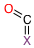

CO*(14) bond orders:{'C': 0.5, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


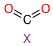

CO2*(15) bond orders:{'C': 0.0, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 1.0}


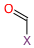

HCO*(16) bond orders:{'C': 0.25, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


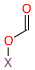

HCOO*(17) bond orders:{'C': 0.0, 'O': 0.5, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


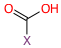

COOH*(18) bond orders:{'C': 0.25, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


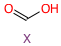

HCOOH*(19) bond orders:{'C': 0.0, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 1.0}


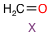

CH2O*(20) bond orders:{'C': 0.0, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 1.0}


CH3O*(21) bond orders:{'C': 0.0, 'O': 0.5, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


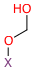

CH3O2*(22) bond orders:{'C': 0.0, 'O': 0.5, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


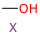

CH3OH*(23) bond orders:{'C': 0.0, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 1.0}


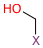

CH3OX(45) bond orders:{'C': 0.25, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


CH3X(55) bond orders:{'C': 0.25, 'O': 0.0, 'N': 0.0, 'H': 0.0, 'vdw': 0.0}


In [9]:

"""
""" 
# get the bond order and original BE
bond_orders = {}

# We want a test species for each element w/ 2 different bond orders
test_spec = {
    "vdw": "",
    "CS": "", 
    "CD": "",
    "CT": "",
    "OS": "", 
    "OD": "",
    "NS": "",
    "ND": "",
    "HS": "",
}
original_be = {}
for spec in model.species: 
    if spec.contains_surface_site():

        adatoms = spec.molecule[0].get_adatoms()
        surface_sites = []
        isvdw = False
        for atom in spec.molecule[0].atoms:
            if atom.is_surface_site():
                surface_sites.append(atom)
        normalized_bonds = {'C': 0., 'O': 0., 'N': 0., 'H': 0., 'vdw': 0.}
        max_bond_order = {'C': 4., 'O': 2., 'N': 3., 'H': 1.,} 
        

        for site in surface_sites:
            numbonds = len(site.bonds)
            if numbonds == 0 and len(spec.molecule[0].atoms) > 1:
                isvdw = True
                normalized_bonds['vdw'] = 1.
                pass
            elif numbonds == 0 and len(spec.molecule[0].atoms) == 1:
                print("empty surface site, skipping")
                pass
            else:
                assert len(site.bonds) == 1, "Each surface site can only be bonded to 1 atom"
                bonded_atom = list(site.bonds.keys())[0]
                bond = site.bonds[bonded_atom]
                if bond.is_single():
                    bond_order = 1.
                elif bond.is_double():
                    bond_order = 2.
                elif bond.is_triple():
                    bond_order = 3.
                elif bond.is_quadruple():
                    bond_order = 4.

                normalized_bonds[bonded_atom.symbol] += bond_order / max_bond_order[bonded_atom.symbol]


        spec_ct_label = f"{spec.label}({spec.index})"
        bond_orders[spec_ct_label] = normalized_bonds
        display(spec)
        print(f"{spec.label}({spec.index}) bond orders:{bond_orders[spec_ct_label]}")
        
        # test species
        if normalized_bonds['vdw'] == 1. and len(test_spec['vdw']) == 0:
            test_spec['vdw'] = spec_ct_label
        elif normalized_bonds['C'] == 0.25 and len(test_spec['CS']) == 0:
            test_spec['CS'] = spec_ct_label
        elif normalized_bonds['C'] == 0.5 and len(test_spec['CD']) == 0:
            test_spec['CD'] = spec_ct_label
        elif normalized_bonds['C'] == 0.75 and len(test_spec['CT']) == 0:
            test_spec['CT'] = spec_ct_label
        elif normalized_bonds['O'] == 0.5 and len(test_spec['OS']) == 0:
            test_spec['OS'] = spec_ct_label
        elif normalized_bonds['O'] == 1. and len(test_spec['OD']) == 0:
            test_spec['OD'] = spec_ct_label
        elif np.isclose(normalized_bonds['N'], 0.3) and len(test_spec['NS']) == 0:
            test_spec['NS'] = spec_ct_label
        elif normalized_bonds['N'] == 1. and len(test_spec['ND']) == 0:
            test_spec['ND'] = spec_ct_label
        elif normalized_bonds['H'] == 1. and len(test_spec['HS']) == 0:
            test_spec['HS'] = spec_ct_label

    else: 
        print(f"{spec.label}({spec.index}) is a gas phase species")
        pass
# perturb each species BE via lsr
thermo_pert_file = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "thermo_pert.yaml")
with open(thermo_pert_file, 'w') as f:
    yaml.safe_dump(bond_orders, f, sort_keys=False)

# make the last values of the pert_dict the original BE
if len(rule_list) ==
    rule_list.extend([0,0,0,0,0])



In [ ]:
# make list of perturbations
import numpy as np
thermo_pert_list = [-3e7,-2e7,1e7,1e7,2e7] 

# load in the perts to a dict
thermo_pert_dict = {'C': 0., 'O': 0., 'N': 0., 'H': 0., 'vdw': 0.}
for num, (key, value) in enumerate(thermo_pert_dict.items()):
    thermo_pert_dict[key] = thermo_pert_list[num]

# now load the perturbations to the cantera thermo
thermo_pert_file = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "thermo_pert.yaml")
with open(thermo_pert_file, 'r') as f:
    bond_orders = yaml.safe_load(f)

# load the cantera mechanism
cti_path = os.path.join(prefix, "rmg_gua", "baseline", "cantera", "chem_annotated.cti")
gas = ct.Solution(cti_path, "gas")
surf = ct.Interface(cti_path, "surface1", [gas])

# dh is range of 0.3 eV, or 1e7 j/kmol
kj_thermo_pert = {k: v/1e6 for k, v in thermo_pert_dict.items()}
print("perts kj/mol: ", kj_thermo_pert)

old_h298 = {}
for spec in surf.species():
    if spec.name == "X(1)":
        print(spec.name)
        pass
    else:
        dh = 0. 

        species = spec.name
        if species in test_spec.values():
            old_h298[species] = spec.thermo.h(298.15)/1e6
        # calculate dh
        bo_spec = bond_orders[species] 
        for atom, value in bo_spec.items():
            dh += thermo_pert_dict[atom] * value

        st_orig = spec.thermo

        coeffs = st_orig.coeffs
        coeffs[[6, 13]] += dh / ct.gas_constant
        s_new = ct.NasaPoly2(st_orig.min_temp, st_orig.max_temp, st_orig.reference_pressure, coeffs)
        spec.thermo = s_new
        surf.modify_species(surf.species_index(species), spec)

        if species in test_spec.values():
            print(f"old h298: {species}", old_h298[species])
            print("new h298: ", spec.thermo.h(298.15)/1e6)
            diff = spec.thermo.h(298.15)/1e6 - old_h298[species]

            print("diff: ", diff)

            pert = dh/1e6

            assert np.isclose(diff, pert, rtol=1e-3, atol=1e-3)
# get thermo perturbations in kj/mol

# test that perturbations are correct (should change by perturbation value at 298K)
# does not acount for bidentates
for bo, spec in test_spec.items():
    if len(spec) > 0:
        if bo == "vdw":
            expected_diff = kj_thermo_pert["vdw"]
        elif bo == "CS":
            expected_diff = kj_thermo_pert["C"] * 0.25
        elif bo == "CD":
            expected_diff = kj_thermo_pert["C"] * 0.5
        elif bo == "CT":
            expected_diff = kj_thermo_pert["C"] * 0.75
        elif bo == "OS":
            expected_diff = kj_thermo_pert["O"] * 0.5
        elif bo == "OD":
            expected_diff = kj_thermo_pert["O"] * 1.0
        elif bo == "NS":
            expected_diff = kj_thermo_pert["N"] / 3
        elif bo == "ND":
            expected_diff = kj_thermo_pert["N"] *(2/3)
        elif bo == "HS":
            expected_diff = kj_thermo_pert["H"] * 1.0

        thermo_new = surf.species(surf.species_index(spec)).thermo
        diff = thermo_new.h(298.15)/1e6 - old_h298[spec]
        print(f"compare {bo} pert to actual pert for {spec}")
        print("diff: ", diff)
        print("expected diff: ", expected_diff)
    
        assert np.isclose(diff, expected_diff, rtol=1e-3, atol=1e-3), f"{bo} perturbation is not correct"


perts kj/mol:  {'C': -30.0, 'O': -20.0, 'N': 10.0, 'H': 10.0, 'vdw': 20.0}
X(1)
old h298: H*(10) -10.557342306971785
new h298:  -0.5573423069717843
diff:  10.0
old h298: O*(11) -178.7060982439154
new h298:  -198.70609824391542
diff:  -20.00000000000003
old h298: OH*(12) -174.95560243281275
new h298:  -184.95560243281273
diff:  -9.999999999999972
old h298: H2O*(13) -263.45003347211446
new h298:  -243.45003347211448
diff:  19.99999999999997
old h298: CO*(14) -181.81664416005242
new h298:  -196.81664416005242
diff:  -15.0
old h298: HCO*(16) -174.55637161010625
new h298:  -182.05637161010628
diff:  -7.500000000000028
compare vdw pert to actual pert for H2O*(13)
diff:  19.99999999999997
expected diff:  20.0
compare CS pert to actual pert for HCO*(16)
diff:  -7.500000000000028
expected diff:  -7.5
compare CD pert to actual pert for CO*(14)
diff:  -15.0
expected diff:  -15.0
compare OS pert to actual pert for OH*(12)
diff:  -9.999999999999972
expected diff:  -10.0
compare OD pert to actual pe

In [95]:
thermo_new.h(298.15)/1e6

-243.45003347211448

In [96]:
old_h298

{'H*(10)': -10.557342306971785,
 'O*(11)': -178.7060982439154,
 'OH*(12)': -174.95560243281275,
 'H2O*(13)': -263.45003347211446,
 'CO*(14)': -181.81664416005242,
 'HCO*(16)': -174.55637161010625}

### Now change the cantera mechanism using values from the two dictionaries

In [9]:
def get_ea(E0, alpha, hrxn):
    """
    get the activation energy from the E0 and alpha values
    """
    return float(E0 + alpha * hrxn)

In [25]:
# load the cantera mechanism
ck_rule_dict_path = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "ck_rule_dict.yaml")
cti_path = os.path.join(prefix, "rmg_gua", "baseline", "cantera", "chem_annotated.cti")
gas = ct.Solution(cti_path, "gas")
surf = ct.Interface(cti_path, "surface1", [gas])

"""
find the template for a given reaction
for now, we don't really care about gas phase rxns
"""
ck_rule_dict_path = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "ck_rule_dict.yaml")
with open(ck_rule_dict_path, 'r') as f:
    ck_rule_dict = yaml.load(f, Loader=yaml.FullLoader)

rule_config_file = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "rule_config.yaml")
with open(rule_config_file, "r") as f:
    rule_dict = yaml.safe_load(f)
bad_rxns = 0
for ck_items in ck_rule_dict:
    ck_rxn = list(ck_items.keys())[0] 
    ck_data = list(ck_items.values())[0]
    ck_reac = collections.Counter(ck_data["reactants"])
    ck_prod = collections.Counter(ck_data["products"])
    for num, rxn in enumerate(surf.reactions()):
        reaclist = []
        prodlist = []
        for reac, stoic in rxn.reactants.items():
            if stoic > 1:
                reaclist.extend([reac]*int(stoic))
            else:
                reaclist.append(reac)

        for reac, stoic in rxn.products.items():
            if stoic > 1:
                prodlist.extend([reac]*int(stoic))
            else:
                prodlist.append(reac)

        reactants = collections.Counter(reaclist)
        products = collections.Counter(prodlist)

        fwd = reactants == ck_reac and products == ck_prod
        rev = reactants == ck_prod and products == ck_reac

        # if we have a match, write the A, Ea to the ct rxn
        if fwd:
            if num in ck_matches.keys():
                print(f"duplicate reaction found {ck_rxn}, moving to next rxn")
                pass
            else: 
                new_rxn = surf.reactions()[num]
                # print("oldrxn: ", surf.reactions()[num].rate)

                A_old = surf.reactions()[num].rate.pre_exponential_factor
                Ea_old = surf.reactions()[num].rate.activation_energy

                # pull the A, Ea from the chemkin file
                A_src = rule_dict[ck_data["source"]]["A"]
                E0_src = rule_dict[ck_data["source"]]["E0"]
                alpha_src = rule_dict[ck_data["source"]]["alpha"]
                hrxn = surf.delta_standard_enthalpy[num] 

                # get nreactants for A unit consistency
                n_reactants = len(ck_data["reactants"])

                # record initial values from cantera
                A_i = surf.reactions()[num].rate.pre_exponential_factor
                Ea_i = surf.reactions()[num].rate.activation_energy
                b_i = surf.reactions()[num].rate.temperature_exponent
                
                if ck_data["rtype"] == "arrhenius":
                    A_i = 10**float(A_src)
                    # for bimolecular reactions we have m^2/mol*s in chemkin, 
                    # but m^2/kmol*s in cantera. all others are either sticking 
                    # (trimolecular dissociative rxns) or unimolecular (units 1/s)
                    if n_reactants == 2:
                        A_i = A_i*1e3
                elif ck_data["rtype"] == "stick":
                    A_i = float(A_src)
                else:
                    raise Exception("reaction type not recognized")
                
                # account for rxn path degeneracy
                if ck_data["deg"] > 1.0:
                    A_i = A_i * ck_data["deg"]
                
                # units j/mol in chemkin, j/kmol in cantera
                E0_src = E0_src*1e3
                Ea_i = get_ea(E0_src, alpha_src, hrxn)

                # set to 0 if negative
                if Ea_i < 0:
                    Ea_i = 0.0

                    
                rate = ct.Arrhenius(A = A_i, E = Ea_i, b = b_i)
                new_rxn.rate = rate
                # print("new rxn rate", rate)
                surf.modify_reaction(num, new_rxn)
                a_match = np.isclose(A_old, A_i, rtol=1e-3)
                e_match = np.isclose(Ea_old, Ea_i, rtol=1e-3)
                ck_matches[num] = ck_num
                if not a_match and not e_match:
                    print(f"reaction {rxn.equation} doesn't match A or Ea")
                    print("source: ", ck_data["source"])
                    print("oldrxn: ", A_old, Ea_old)
                    print("newrxn: ", 
                    surf.reactions()[num].rate.pre_exponential_factor, surf.reactions()[num].rate.activation_energy)
                    bad_rxns += 1
                elif not a_match and e_match:
                    print(f"reaction {rxn.equation} doesn't match A")
                    print("source: ", ck_data["source"])
                    print("oldrxn: ", A_old, Ea_old)
                    print("newrxn: ", 
                    surf.reactions()[num].rate.pre_exponential_factor, surf.reactions()[num].rate.activation_energy) 
                    bad_rxns += 1
                elif a_match and not e_match:
                    print(f"reaction {rxn.equation} doesn't match Ea")
                    print("source: ", ck_data["source"])
                    print("oldrxn: A = {:.2e} Ea = {:.2e}".format(A_old, Ea_old))
                    print("newrxn: A = {:.2e} Ea = {:.2e}".format(
                        surf.reactions()[num].rate.pre_exponential_factor, 
                        surf.reactions()[num].rate.activation_energy))
                    bad_rxns += 1
        if rev: 
            raise Exception("reverse of chemkin reaction found in ct")
        

            
# # rule config in db
# rule_config

# # family and node info from ck
# ck_rule_dict_path


duplicate reaction found X(1) + H2O(5) <=> H2O*(13), moving to next rxn
duplicate reaction found X(1) + CO2(4) <=> CO2*(15), moving to next rxn
duplicate reaction found H*(10) + CO2(4) <=> HCOO*(17), moving to next rxn
duplicate reaction found HCOO*(17) <=> COOH*(18), moving to next rxn
duplicate reaction found H*(10) + CO2(4) <=> COOH*(18), moving to next rxn
duplicate reaction found X(1) + HCOOH(7) <=> HCOOH*(19), moving to next rxn
duplicate reaction found X(1) + CH2O(6) <=> CH2O*(20), moving to next rxn
duplicate reaction found H*(10) + CH2O(6) <=> CH3O*(21), moving to next rxn
duplicate reaction found OH*(12) + CH2O(6) <=> CH3O2*(22), moving to next rxn
duplicate reaction found H*(10) + HCOOH(7) <=> CH3O2*(22), moving to next rxn
duplicate reaction found X(1) + CH3OH(8) <=> CH3OH*(23), moving to next rxn
duplicate reaction found X(1) + X(1) + H2(2) <=> H*(10) + H*(10), moving to next rxn
duplicate reaction found X(1) + X(1) + CO2(4) <=> O*(11) + CO*(14), moving to next rxn
duplica

# below is a test, put it in a separate script before running 

In [26]:
# iterate through chemkin and cantera reactions again
# check for exact matches, since duplicates are all out of order
# load the cantera mechanism
ck_rule_dict_path = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "ck_rule_dict.yaml")
cti_path = os.path.join(prefix, "rmg_gua", "baseline", "cantera", "chem_annotated.cti")
# gas = ct.Solution(cti_path, "gas")
# surf = ct.Interface(cti_path, "surface1", [gas])

"""
find the template for a given reaction
for now, we don't really care about gas phase rxns
"""
ck_rule_dict_path = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "ck_rule_dict.yaml")
with open(ck_rule_dict_path, 'r') as f:
    ck_rule_dict = yaml.load(f, Loader=yaml.FullLoader)

rule_config_file = os.path.join(prefix, "rmg_gua", "gua_peuqse", "02_opt_logp_fam_be", "rule_config.yaml")
with open(rule_config_file, "r") as f:
    rule_dict = yaml.safe_load(f)
ck_matches = {}
ck_no_match = []
for ck_num, ck_items in enumerate(ck_rule_dict):
    ck_rxn = list(ck_items.keys())[0] 
    ck_data = list(ck_items.values())[0]
    ck_reac = collections.Counter(ck_data["reactants"])
    ck_prod = collections.Counter(ck_data["products"])
    for num, rxn in enumerate(surf.reactions()):
        reaclist = []
        prodlist = []
        for reac, stoic in rxn.reactants.items():
            if stoic > 1:
                reaclist.extend([reac]*int(stoic))
            else:
                reaclist.append(reac)

        for reac, stoic in rxn.products.items():
            if stoic > 1:
                prodlist.extend([reac]*int(stoic))
            else:
                prodlist.append(reac)

        reactants = collections.Counter(reaclist)
        products = collections.Counter(prodlist)

        fwd = reactants == ck_reac and products == ck_prod
        rev = reactants == ck_prod and products == ck_reac

        # if we have a match, write the A, Ea to the ct rxn
        if fwd:
            if num in ck_matches.keys():
                print("duplicate reaction found, moving to next rxn")
                pass
            # new_rxn = surf.reactions()[num]
            # print("oldrxn: ", surf.reactions()[num].rate)

            A_old = ck_data["reac_dict"]["A"]
            Ea_old = ck_data["reac_dict"]["Ea"]

            # record initial values from cantera
            A_i = surf.reactions()[num].rate.pre_exponential_factor
            Ea_i = surf.reactions()[num].rate.activation_energy

            n_reactants = len(ck_data["reactants"])

            if ck_data["rtype"] == "arrhenius":
                A_old = 10**float(A_old)
                # for bimolecular reactions we have m^2/mol*s in chemkin, 
                # but m^2/kmol*s in cantera. all others are either sticking 
                # (trimolecular dissociative rxns) or unimolecular (units 1/s)
                if n_reactants == 2:
                    A_old = A_old*1e3
            elif ck_data["rtype"] == "stick":
                A_old = float(A_old)
            else:
                raise Exception("reaction type not recognized")

            # units j/mol in chemkin, j/kmol in cantera
            Ea_old = Ea_old*1e3

            # print("new rxn rate", rate)
            # surf.modify_reaction(num, new_rxn)
            a_match = np.isclose(A_old, A_i, rtol=1e-3)
            e_match = np.isclose(Ea_old, Ea_i, rtol=1e-3)

            if a_match and e_match:
                if num in ck_matches.keys():
                    if num >= len(surf.reactions())-2: 
                        print(f"reaction {rxn.equation} doesn't match A or Ea")
                        print("source: ", ck_data["source"])
                        print("oldrxn: ", A_old, Ea_old)
                        print("newrxn: ", 
                        surf.reactions()[num].rate.pre_exponential_factor, surf.reactions()[num].rate.activation_energy)
                        ck_no_match.append(ck_items)
                    pass
                else: 
                    ck_matches[num] = ck_num
                    break

        if rev: 
            raise Exception("reverse of chemkin reaction found in ct")


duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate reaction found, moving to next rxn
duplicate 

In [27]:
ck_no_match

[]

In [28]:
no_match_ct = list(set(range(len(surf.reactions()))) - set(ck_matches.keys()))

for i in no_match_ct:
    print(surf.reactions()[i].equation, surf.reactions()[i].rate)

CH3OH(8) + 2 X(1) <=> CH3X(55) + OH*(12) Arrhenius(A=0.1, b=0, E=1.29211e+08)
HCOOCH3(9) + 2 X(1) <=> CH3X(55) + HCOO*(17) Arrhenius(A=0.1, b=0, E=4.11753e+07)
CH3OH*(23) + CO*(14) <=> CH3X(55) + COOH*(18) Arrhenius(A=1e+16, b=0, E=5.05301e+06)
C(40) + 2 X(1) <=> CH3X(55) + H*(10) Arrhenius(A=3.02, b=0, E=5.8e+07)
HCOOH(7) + 2 X(1) <=> HCO*(16) + OH*(12) Arrhenius(A=0.1, b=0, E=1.27892e+08)
HCOOCH3(9) + 2 X(1) <=> CH3O*(21) + HCO*(16) Arrhenius(A=0.1, b=0, E=1.11539e+08)
CO2*(15) + X(1) <=> CO*(14) + O*(11) Arrhenius(A=2e+16, b=0, E=3.05863e+07)
H*(10) + HCOOH*(19) <=> CH3O2*(22) + X(1) Arrhenius(A=1e+16, b=0, E=5.26255e+07)
CO*(14) + H2O*(13) <=> COOH*(18) + H*(10) Arrhenius(A=2e+16, b=0, E=6.20872e+06)
CH3OH*(23) + O*(11) <=> CH3O2*(22) + H*(10) Arrhenius(A=3e+16, b=0, E=1.60999e+07)
CH2O*(20) + H2O*(13) <=> CH3O2*(22) + H*(10) Arrhenius(A=2e+16, b=0, E=0)
H2O*(13) + O*(11) <=> 2 OH*(12) Arrhenius(A=2e+16, b=0, E=4.6133e+07)
HCOOH*(19) + O*(11) <=> COOH*(18) + OH*(12) Arrhenius(A=1e+

In [20]:
ck_rule_dict[12].keys()

dict_keys(['X(1) + X(1) + CO2(4) <=> O*(11) + CO*(14)'])

In [29]:
for key, value in ck_matches.items():
    rxstr = list(ck_rule_dict[value].keys())[0]
    n_reactants = len(ck_rule_dict[value][rxstr]["reactants"])
    ck_A = ck_rule_dict[value][rxstr]["reac_dict"]["A"]
    ck_Ea = ck_rule_dict[value][rxstr]["reac_dict"]["Ea"]
    ct_A = surf.reactions()[key].rate.pre_exponential_factor
    ct_Ea = surf.reactions()[key].rate.activation_energy

    ck_Ea = ck_Ea*1e3
    if ct_A > 1.0: 
        ck_A = 10**ck_A
        if n_reactants ==2:
            ck_A = ck_A*1e3

    if not np.isclose(ck_A, ct_A, rtol=1e-3):
        print(f"rxn {key}: {rxstr}")
        print(f"ck: {ck_A}, {ck_Ea}")
        print(f"ct: {ct_A}, {ct_Ea}")
    elif not np.isclose(ck_Ea, ct_Ea, rtol=1e-3):
        print(f"rxn {key}: {rxstr}")
        print(f"ck: {ck_A}, {ck_Ea}")
        print(f"ct: {ct_A}, {ct_Ea}")


### redo Ea calc from BEP to verify we get the same answer

In [15]:
rxn_str = "OH*(12) + CH2O*(20) <=> H*(10) + HCOOH*(19)"
ck_source = ck_vals["source"]
ck_vals = ck_rule_dict[rxn_str]
dHrxn = ck_vals["dHrxn"]
for num, rxn in enumerate(surf.reactions()):
    if "OH*(12)" in rxn.reactants and "CH2O*(20)" in rxn.reactants and "H*(10)" in rxn.products \
         and "HCOOH*(19)" in rxn.products: 
        print(surf.delta_standard_enthalpy[num]/1e3, dHrxn)

NameError: name 'ck_vals' is not defined

142

In [ ]:
### redo Ea calc from BEP to verify we get the same answer
rxn_str = "OH*(12) + CH2O*(20) <=> H*(10) + HCOOH*(19)"
ck_source = ck_vals["source"]
ck_vals = ck_rule_dict[rxn_str]
dHrxn = ck_vals["dHrxn"]
for num, rxn in enumerate(surf.reactions()):
    if "OH*(12)" in rxn.reactants and "CH2O*(20)" in rxn.reactants and "H*(10)" in rxn.products \
         and "HCOOH*(19)" in rxn.products: 
        print(surf.delta_standard_enthalpy[num]/1e3, dHrxn)
# get chemkin values
rxn_str = "OH*(12) + CH2O*(20) <=> H*(10) + HCOOH*(19)"
ck_source = ck_vals["source"]
ck_vals = ck_rule_dict[rxn_str]
dHrxn = ck_vals["dHrxn"]

# get rmg rule db values
E0 = rule_dict[ck_source]["E0"]
alpha = rule_dict[ck_source]["Alpha"]
Ea_calc = E0+alpha*(dHrxn)
if Ea_calc < 0.0:
    Ea_calc = 0.0
Ea_calc, ck_vals["reac_dict"]["Ea"], dHrxn

In [ ]:
with open